# Reproducing Figure 4

In this figure, we vary configuration 1 as follows:

* Number of delivery beds: 2 or 3
* Delivery arrivals: 1, 1.5 or 2 per day
    * 1 = IAT 1440 (as in e.g. config1)
    * 1.5 = 960 (as 720+240=960, and 960+480=1440)
    * 2 = IAT 720 (as we did for Figure 3)

## Set up

In [1]:
# To run model
import PHC

# To import results and produce figures
import xlrd
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import itertools

# To speed up run time
from multiprocessing import Pool

'''# Additional package to record runtime of this notebook
import time
start = time.time()'''

'# Additional package to record runtime of this notebook\nimport time\nstart = time.time()'

In [2]:
# Paths to save image files to
output_folder = 'outputs'
fig4_path = os.path.join(output_folder, 'fig4.png')

## Run model

In [3]:
# TODO: Run with 100 replications

# Varying number of childbirth cases
arr_dict = [
    {
        'delivery_iat': 1440,
        'rep_file': 'arr1440'
    },
    {
        'delivery_iat': 1080,
        'rep_file': 'arr1080'
    },
    {
        'delivery_iat': 960,
        'rep_file': 'arr960'
    },
    {
        'delivery_iat': 720,
        'rep_file': 'arr720'
    }
]

# Varying the number of beds
bed_dict = [
    {
        'delivery_bed_n': 1,
        'rep_file': 'bed1'
    },
    {
        'delivery_bed_n': 2,
        'rep_file': 'bed2'
    }
]

Create each combination for the reproduction

In [4]:
dict_list = []
for arr in arr_dict:
    for bed in bed_dict:
        # Combine the dictionaries
        comb = {**arr, **bed}
        # Replace the file name
        comb['rep_file'] = f'''f4_{arr['rep_file']}_{bed['rep_file']}.xls'''
        # Save to list
        dict_list.append(comb)

len(dict_list)

8

In [5]:
# Append 's_' to all items
for i, d in enumerate(dict_list):
    dict_list[i] = {f's_{k}': v for k, v in d.items()}

# Preview example
dict_list[0]

{'s_delivery_iat': 1440,
 's_rep_file': 'f4_arr1440_bed1.xls',
 's_delivery_bed_n': 1}

Run the model (with parallel processing to reduce run time)

In [6]:
'''# Wrapper function to allow input of dictionary with pool
def wrapper(d):
    return PHC.main(**d)

# Create a process pool that uses all CPUs
with Pool(8) as pool:
    # Run PHC.main() using each of inputs from config
    pool.map(wrapper, dict_list)'''

'# Wrapper function to allow input of dictionary with pool\ndef wrapper(d):\n    return PHC.main(**d)\n\n# Create a process pool that uses all CPUs\nwith Pool(8) as pool:\n    # Run PHC.main() using each of inputs from config\n    pool.map(wrapper, dict_list)'

## Process results

In [7]:
def process_results(files):
    '''
    Imports files in provided list and produces a single dataframe with mean
    results from across the replications

    Parameters:
    ----------
    files : list
        List of file names (exc. file type) containing replication results

    Returns:
    --------
    summary : dataframe
        Dataframe with mean results for each model variant in file list
    '''
    # Empty list to store results
    result_list = []

    for f in files:
        # Import .xls and convert to pandas dataframe
        book = xlrd.open_workbook(os.path.join(output_folder, f))
        result = pd.read_excel(book, header=None, index_col=0)

        # Add proportion of childbirth cases referred
        result.loc['prop_del_referred'] = (
            result.loc['del referred'] / result.loc['Del patients'])

        # Find mean from the replication
        # Save as dataframe, dropping the duplicate rows (NCD occ twice)
        res = pd.DataFrame({f: result.mean(axis=1)}).drop_duplicates()

        # Remove index name
        res.index.name = None

        # Remove .xls from column names
        res.columns = res.columns.str.removesuffix('.xls')

        # Save to list
        result_list.append(res)

    # Combine into single dataframe
    summary = pd.concat(result_list, axis=1)

    return summary

In [8]:
data = process_results([i['s_rep_file'] for i in dict_list])
data.head()

,f4_arr1440_bed1,f4_arr1440_bed2,f4_arr1080_bed1,f4_arr1080_bed2,f4_arr960_bed1,f4_arr960_bed2,f4_arr720_bed1,f4_arr720_bed2
OPD patients,33139.900000,33121.800000,33045.000000,33190.500000,33070.500000,33153.500000,33136.000000,33202.800000
IPD patients,185.500000,176.000000,184.600000,175.800000,182.100000,184.800000,182.800000,187.500000
ANC patients,364.300000,365.400000,367.700000,366.400000,352.000000,360.700000,372.600000,364.000000
Del patients,364.800000,359.800000,501.500000,486.600000,550.600000,546.800000,734.500000,733.600000
OPD Q wt,0.008448,0.008676,0.009153,0.010267,0.013715,0.012359,0.021986,0.015481


## Create Figure 4

In [9]:
# Select series with proportion referred
a4 = data.loc['prop_del_referred']

# Reshape into appropriate format for plotting
names = ['1 (IAT 1440)', '1.5 (IAT 960)', '1.5 (IAT1080)', '2 (IAT 720)']
bed1 = [a4['f4_arr1440_bed1'], a4['f4_arr960_bed1'],
        a4['f4_arr1080_bed1'], a4['f4_arr720_bed1']]
bed2 = [a4['f4_arr1440_bed2'], a4['f4_arr960_bed2'],
        a4['f4_arr1080_bed2'], a4['f4_arr720_bed2']]

data_4a = pd.DataFrame({'1 bed': bed1, '2 beds': bed2}, index=names)
data_4a

,1 bed,2 beds
1 (IAT 1440),0.157425,0.015504
1.5 (IAT 960),0.224336,0.036134
1.5 (IAT1080),0.206583,0.031020
2 (IAT 720),0.275549,0.064164


### Function to create figure

In [10]:
def create_figure4(df):
    '''
    Produces figure 4
    '''
    # Plot data
    ax = df.plot(kind='line', color='black')

    # Add markers
    for l, ms in zip(ax.lines, itertools.cycle('so')):
        l.set_marker(ms)
        l.set_color('black')
    ax.legend(title='Number of delivery beds')

    # Add labels to each point
    for line in ax.lines:
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        for x, y in zip(x_data, y_data):
            ax.annotate(f'{y:.3f}', xy=(x, y), xytext=(3, 3),
                        textcoords='offset points', fontsize=9)

    # Adjust figure
    plt.xlabel('Average number of childbirth patients per day')
    plt.ylabel('Proportion of patients referred elsewhere')
    plt.ylim(0, 0.3)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.grid(axis='y')
    ax.set_axisbelow(True)

### Evaluating options

Due to discrepancies observed for 1.5 arrivals, I presumed that the difference could be in the IAT used, since the paper only provides the number of arrivals and not the IAT. I estimated the IAT to be 960, but I also tried using 1080 (which is equidistant between the 1 and 2 arrival IAT values), as I have not identified a formula for how these are produced, and have only been able to estimate.

From comparing the two options, 960 is closer for 2 beds whilst 1080 is closer for 1 bed. Since the difference is greatest for 1 bed, I opted to use that IAT.

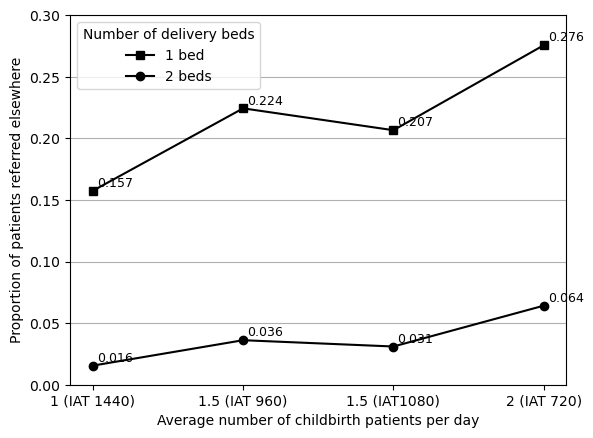

In [11]:
create_figure4(data_4a)
# plt.savefig(fig4_path, bbox_inches='tight')
plt.show()

In [12]:
# Input results from original and reproduced figures
comp = pd.DataFrame({
    'original': [0.021, 0.039, 0.039, 0.0599, 0.150, 0.195, 0.195, 0.270],
    'reproduced': data_4a.iloc[:, 1].to_list() + data_4a.iloc[:, 0].to_list()})
comp['reproduced'] = round(comp['reproduced'], 3)

# Find size of difference and % change
comp['diff'] = comp['reproduced'] - comp['original']
comp['pct_change'] = comp.pct_change(axis=1).iloc[:, 1]*100
comp

,original,reproduced,diff,pct_change
0,0.0210,0.016,-0.0050,-23.809524
1,0.0390,0.036,-0.0030,-7.692308
2,0.0390,0.031,-0.0080,-20.512821
3,0.0599,0.064,0.0041,6.844741
4,0.1500,0.157,0.0070,4.666667
5,0.1950,0.224,0.0290,14.871795
6,0.1950,0.207,0.0120,6.153846
7,0.2700,0.276,0.0060,2.222222


### Chosen figure (with IAT 1080)

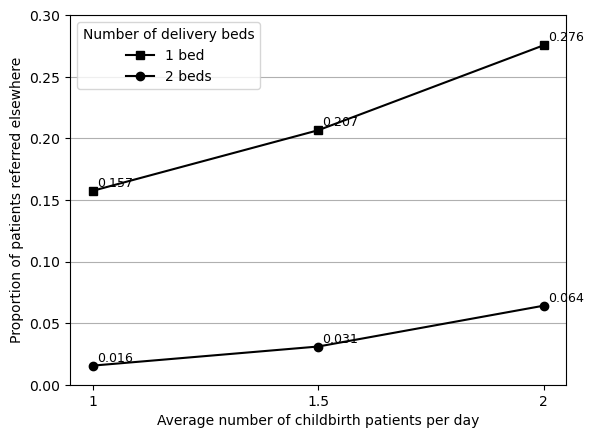

In [13]:
# Drop 960
data_4a_final = data_4a.drop(index='1.5 (IAT 960)')

# Amend labels to match original
data_4a_final.index = [x.split(' (')[0] for x in data_4a_final.index.to_list()]

create_figure4(data_4a_final)
plt.savefig(fig4_path, bbox_inches='tight')
plt.show()

## Run time

In [14]:
'''# Find run time in seconds
end = time.time()
runtime = round(end-start)

# Display converted to minutes and seconds
print(f'Notebook run time: {runtime//60}m {runtime%60}s')'''

"# Find run time in seconds\nend = time.time()\nruntime = round(end-start)\n\n# Display converted to minutes and seconds\nprint(f'Notebook run time: {runtime//60}m {runtime%60}s')"